# TITANIC COMPETITION
---

# Import Libraries

In [227]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pd.set_option("display.expand_frame_repr",False)

# Load Dataset

In [228]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## >> Overview

In [229]:
def dataframe_summary(dataframe, show_value_counts = False):
    import pandas as pd
    pd.set_option("display.colheader_justify","left")
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------- SHAPE of Dataset -----------------------------------------------------------------------------------------------------------------------")
    print(dataframe.shape)
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------- DATA TYPES of Dataset ------------------------------------------------------------------------------------------------------------------")
    print(dataframe.dtypes)
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------- MEMORY USAGE of Dataset --------------------------------------------------------------------------------------------------------------  ")
    print(dataframe.memory_usage(deep=True) / (1024 * 1024))
    print("TOTAL >>> ", round((dataframe.memory_usage(deep=True) / (1024 * 1024)).sum(),2), "\n (All are in MB)")
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------- MISSING VALUES in Dataset --------------------------------------------------------------------------------------------------------------")
    print(dataframe.isnull().sum())
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------- DESCRIPTIVE Info about Dataset ---------------------------------------------------------------------------------------------------------")
    print(dataframe.describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T)
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")

    if show_value_counts:
        print("-------- VALUE COUNTS in Dataset ----------------------------------------------------------------------------------------------------------------")
        for col in dataframe.columns:
            print(dataframe[col].value_counts())
            print("-------------------------------------------------------------------------------------------------------------------------------------------------")

In [230]:
dataframe_summary(df)

-------------------------------------------------------------------------------------------------------------------------------------------------
-------- SHAPE of Dataset -----------------------------------------------------------------------------------------------------------------------
(891, 12)
-------------------------------------------------------------------------------------------------------------------------------------------------
-------- DATA TYPES of Dataset ------------------------------------------------------------------------------------------------------------------
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
--------------------------------------------------------------------------------------------------------------------

## >> Lower All Variable Names and Take an Overview of Dataset

In [231]:
df.columns = [col.lower() for col in df.columns]
print("-"*33)
print(df.shape)
print("-"*33)
print(df.info())
print("-"*33)
print(df.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]).T)
print("-"*33)
df.head()

---------------------------------
(891, 12)
---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
---------------------------------
             count  mean        std         min   1%   5%      10%    25%       50%       75%    90%       95%        99%      

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Creating New Features

## >> Define New Features

In [232]:
# passeger have a cabin
df["n_has_cabin"] = df["cabin"].notnull().astype(int)

# 'dr in name
df["n_name_dr"] = df["name"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

# 'title' in name
df['n_title'] = df["name"].str.extract(' ([A-Za-z]+)\.', expand=False)

# family size
df["n_family_size"] = df["sibsp"] + df["parch"] + 1

# is alone
df.loc[((df['sibsp'] + df['parch']) > 0), "n_is_alone"] = "No"
df.loc[((df['sibsp'] + df['parch']) == 0), "n_is_alone"] = "Yes"

# age level
df.loc[(df['age'] < 18), 'n_age_cat'] = 'Young'
df.loc[(df['age'] >= 18) & (df['age'] < 56), 'n_age_cat'] = 'Mature'
df.loc[(df['age'] >= 56), 'n_age_cat'] = 'Senior'

# sex according to age
df.loc[(df['sex'] == 'male') & (df['age'] <= 21), 'n_sex_cat'] = 'Young male'
df.loc[(df['sex'] == 'male') & (df['age'] > 21) & (df['age'] < 50), 'n_sex_cat'] = 'Mature male'
df.loc[(df['sex'] == 'male') & (df['age'] >= 50), 'n_sex_cat'] = 'Senior male'
df.loc[(df['sex'] == 'female') & (df['age'] <= 21), 'n_sex_cat'] = 'Young female'
df.loc[(df['sex'] == 'female') & (df['age'] > 21) & (df['age'] < 50), 'n_sex_cat'] = 'Mature female'
df.loc[(df['sex'] == 'female') & (df['age'] >= 50), 'n_sex_cat'] = 'Senior female'

print("-"*33)
print("New Shape of Dataset:")
print("-"*33)
print(df.shape)
print("-"*33)
df.head()

---------------------------------
New Shape of Dataset:
---------------------------------
(891, 19)
---------------------------------


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,n_has_cabin,n_name_dr,n_title,n_family_size,n_is_alone,n_age_cat,n_sex_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,Mr,2,No,Mature,Mature male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,Mrs,2,No,Mature,Mature female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,Miss,1,Yes,Mature,Mature female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,Mrs,2,No,Mature,Mature female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,Mr,1,Yes,Mature,Mature male


## >> Define Data Types

In [233]:
df.dtypes

passengerid        int64
survived           int64
pclass             int64
name              object
sex               object
age              float64
sibsp              int64
parch              int64
ticket            object
fare             float64
cabin             object
embarked          object
n_has_cabin        int64
n_name_dr          int64
n_title           object
n_family_size      int64
n_is_alone        object
n_age_cat         object
n_sex_cat         object
dtype: object

In [234]:
cat_cols = ["survived", "pclass", "sex","sibsp","parch","cabin", "embarked","n_name_dr","n_title","n_is_alone","n_age_cat","n_sex_cat"] 
num_cols = ["age","fare","n_family_size"]
car_cols = ["passengerid", "name","ticket"]
target_label = 'survived'

print("-"*33)
print(f"Categorical Variables: {cat_cols}")
print("-"*33)
print(f"Numerical Variables: {num_cols}")
print("-"*33)
print(f"Cardinal Variables: {car_cols}")
print("-"*33)

---------------------------------
Categorical Variables: ['survived', 'pclass', 'sex', 'sibsp', 'parch', 'cabin', 'embarked', 'n_name_dr', 'n_title', 'n_is_alone', 'n_age_cat', 'n_sex_cat']
---------------------------------
Numerical Variables: ['age', 'fare', 'n_family_size']
---------------------------------
Cardinal Variables: ['passengerid', 'name', 'ticket']
---------------------------------


In [235]:
for col in cat_cols:
    print("-"*33)
    print(df[col].value_counts())
    print("-"*33)

---------------------------------
survived
0    549
1    342
Name: count, dtype: int64
---------------------------------
---------------------------------
pclass
3    491
1    216
2    184
Name: count, dtype: int64
---------------------------------
---------------------------------
sex
male      577
female    314
Name: count, dtype: int64
---------------------------------
---------------------------------
sibsp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64
---------------------------------
---------------------------------
parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64
---------------------------------
---------------------------------
cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64
---------------------------------

## >> Explore Data

In [236]:
def categoricals_summary(dataframe, column_name, plot=False):
    print(pd.DataFrame({column_name: dataframe[column_name].value_counts(),
                 "Ratio": 100 * (dataframe[column_name].value_counts() / len(dataframe))}))
    print("--------------------------------------------------------------------------------------------------------")

    if plot:
        sns.countplot(x=dataframe[column_name], data=dataframe)
        plt.show()
        print("--------------------------------------------------------------------------------------------------------")
#--------------------------------------------------------------------------------------------------------        
def numericals_summary(dataframe, column_name, plot = False, plot_bins = 20):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[column_name].describe(quantiles).T)
    print("--------------------------------------------------------------------------------------------------------")
    
    if plot:
        dataframe[column_name].hist(bins = plot_bins)
        plt.xlabel(column_name)
        plt.title(column_name)
        plt.show()
        print("--------------------------------------------------------------------------------------------------------")

          survived  Ratio    
survived                     
0         549       61.616162
1         342       38.383838
--------------------------------------------------------------------------------------------------------


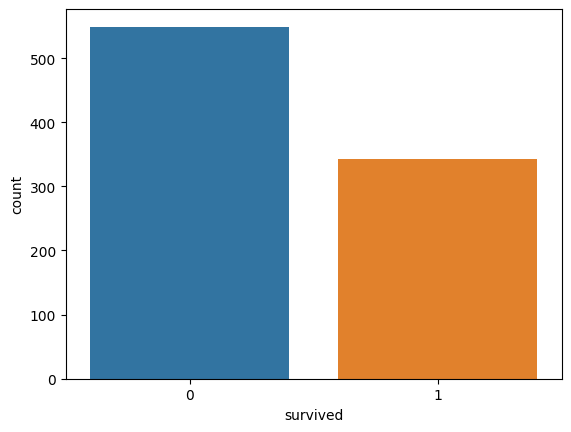

--------------------------------------------------------------------------------------------------------
        pclass  Ratio    
pclass                   
3       491     55.106622
1       216     24.242424
2       184     20.650954
--------------------------------------------------------------------------------------------------------


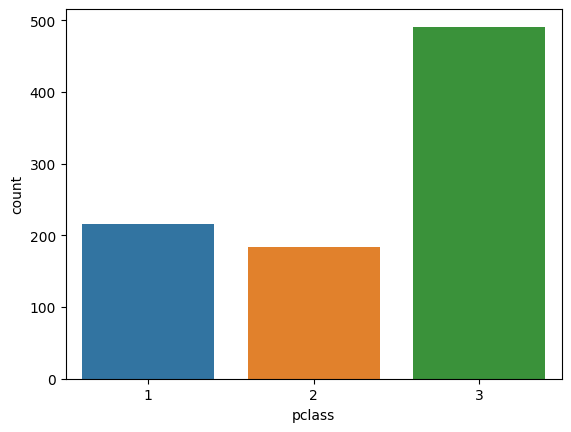

--------------------------------------------------------------------------------------------------------
        sex  Ratio    
sex                   
male    577  64.758698
female  314  35.241302
--------------------------------------------------------------------------------------------------------


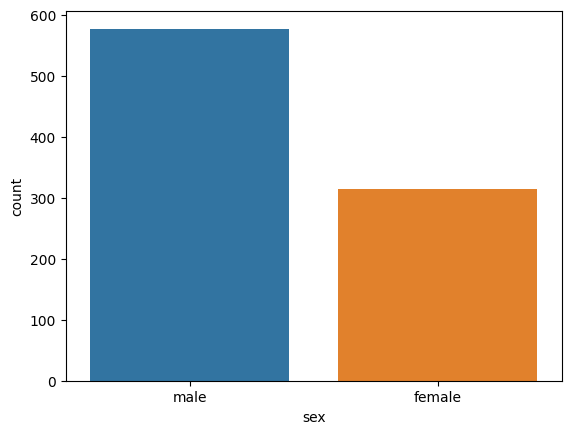

--------------------------------------------------------------------------------------------------------
       sibsp  Ratio    
sibsp                  
0      608    68.237935
1      209    23.456790
2       28     3.142536
4       18     2.020202
3       16     1.795735
8        7     0.785634
5        5     0.561167
--------------------------------------------------------------------------------------------------------


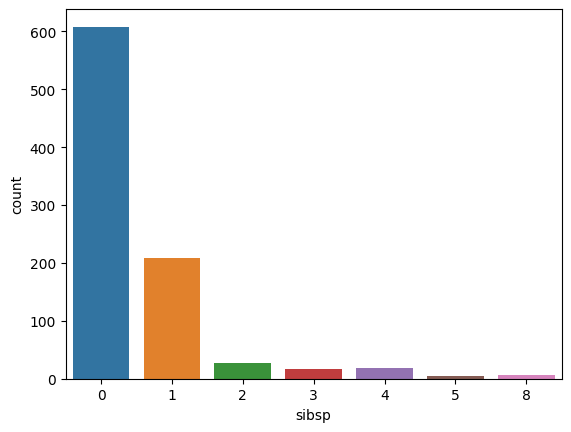

--------------------------------------------------------------------------------------------------------
       parch  Ratio    
parch                  
0      678    76.094276
1      118    13.243547
2       80     8.978676
5        5     0.561167
3        5     0.561167
4        4     0.448934
6        1     0.112233
--------------------------------------------------------------------------------------------------------


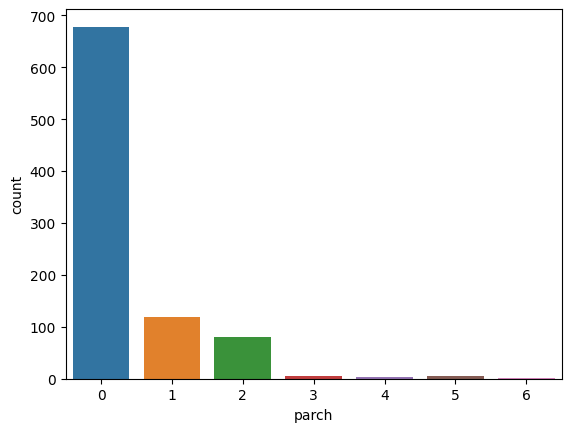

--------------------------------------------------------------------------------------------------------
             cabin  Ratio   
cabin                       
B96 B98      4      0.448934
G6           4      0.448934
C23 C25 C27  4      0.448934
C22 C26      3      0.336700
F33          3      0.336700
...            ...       ...
E34          1      0.112233
C7           1      0.112233
C54          1      0.112233
E36          1      0.112233
C148         1      0.112233

[147 rows x 2 columns]
--------------------------------------------------------------------------------------------------------


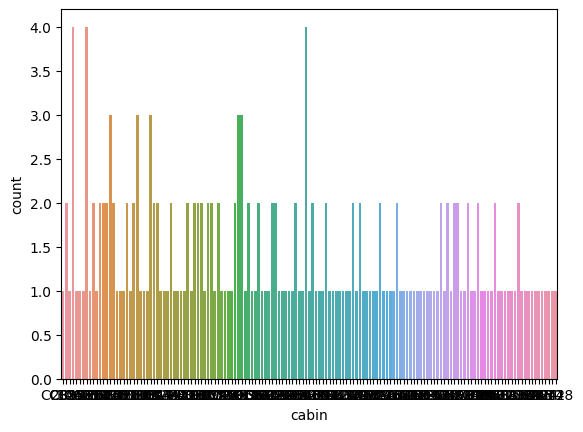

--------------------------------------------------------------------------------------------------------
          embarked  Ratio    
embarked                     
S         644       72.278339
C         168       18.855219
Q          77        8.641975
--------------------------------------------------------------------------------------------------------


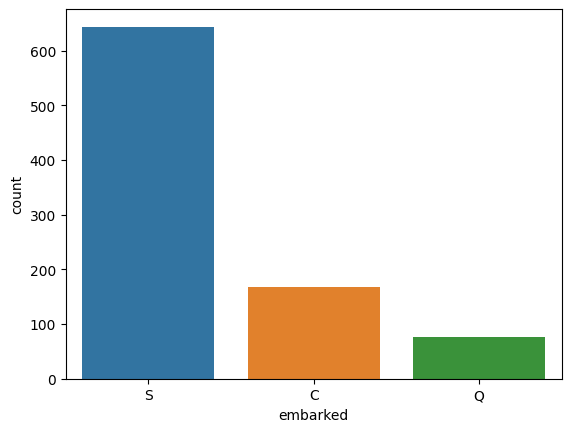

--------------------------------------------------------------------------------------------------------
           n_name_dr  Ratio    
n_name_dr                      
0          881        98.877666
1           10         1.122334
--------------------------------------------------------------------------------------------------------


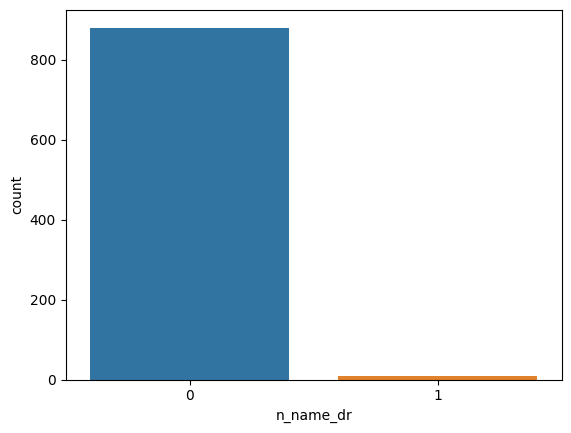

--------------------------------------------------------------------------------------------------------
          n_title  Ratio    
n_title                     
Mr        517      58.024691
Miss      182      20.426487
Mrs       125      14.029181
Master     40       4.489338
Dr          7       0.785634
Rev         6       0.673401
Mlle        2       0.224467
Major       2       0.224467
Col         2       0.224467
Countess    1       0.112233
Capt        1       0.112233
Ms          1       0.112233
Sir         1       0.112233
Lady        1       0.112233
Mme         1       0.112233
Don         1       0.112233
Jonkheer    1       0.112233
--------------------------------------------------------------------------------------------------------


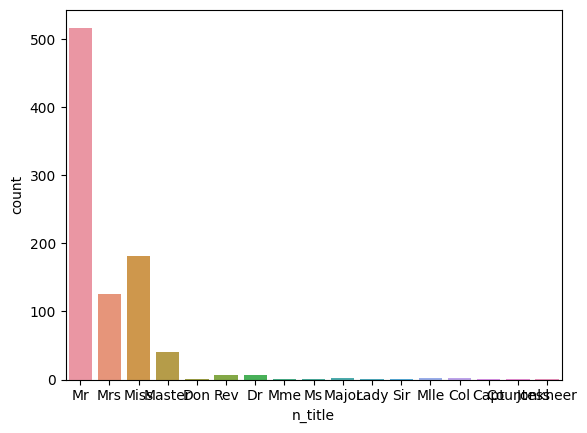

--------------------------------------------------------------------------------------------------------
            n_is_alone  Ratio   
n_is_alone                      
Yes         537         60.26936
No          354         39.73064
--------------------------------------------------------------------------------------------------------


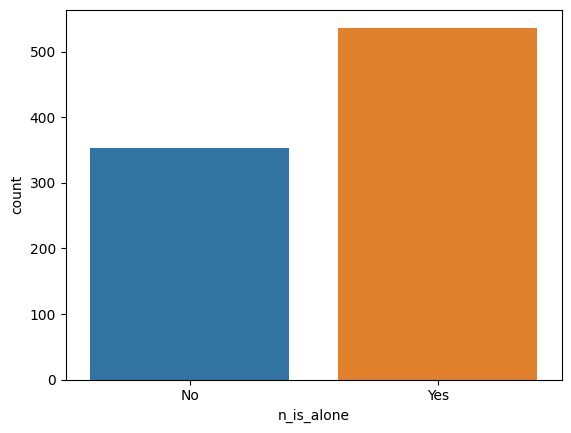

--------------------------------------------------------------------------------------------------------
           n_age_cat  Ratio    
n_age_cat                      
Mature     562        63.075196
Young      113        12.682379
Senior      39         4.377104
--------------------------------------------------------------------------------------------------------


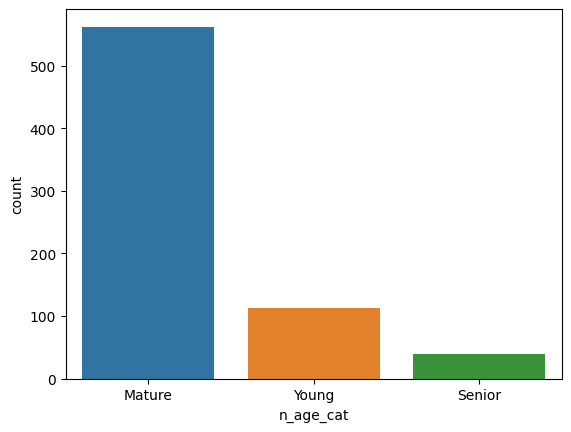

--------------------------------------------------------------------------------------------------------
               n_sex_cat  Ratio    
n_sex_cat                          
Mature male    281        31.537598
Mature female  155        17.396184
Young male     120        13.468013
Young female    84         9.427609
Senior male     52         5.836139
Senior female   22         2.469136
--------------------------------------------------------------------------------------------------------


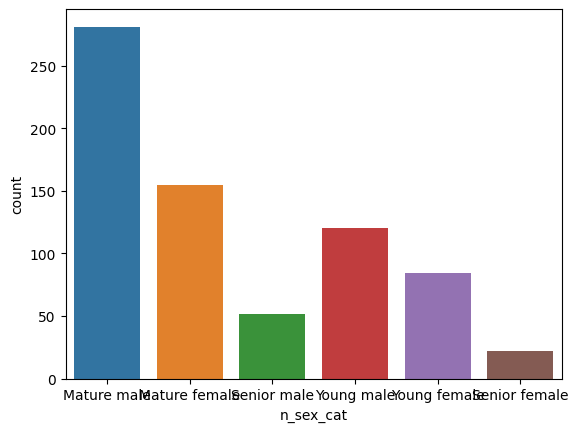

--------------------------------------------------------------------------------------------------------


In [237]:
for col in cat_cols:
    categoricals_summary(df, column_name = col, plot=True)

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
5%         4.000000
10%       14.000000
20%       19.000000
30%       22.000000
40%       25.000000
50%       28.000000
60%       31.800000
70%       36.000000
80%       41.000000
90%       50.000000
95%       56.000000
99%       65.870000
max       80.000000
Name: age, dtype: float64
--------------------------------------------------------------------------------------------------------


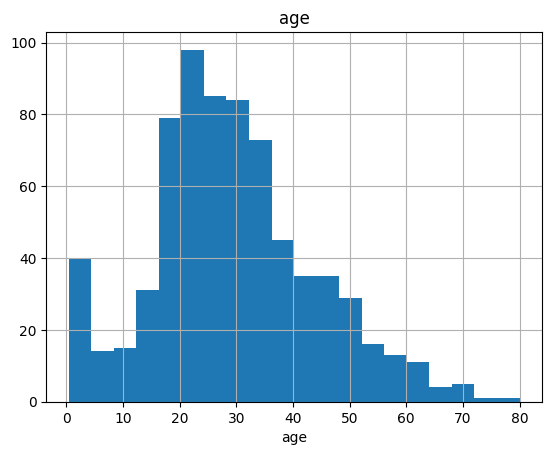

--------------------------------------------------------------------------------------------------------
count    891.000000
mean      32.204208
std       49.693429
min        0.000000
5%         7.225000
10%        7.550000
20%        7.854200
30%        8.050000
40%       10.500000
50%       14.454200
60%       21.679200
70%       27.000000
80%       39.687500
90%       77.958300
95%      112.079150
99%      249.006220
max      512.329200
Name: fare, dtype: float64
--------------------------------------------------------------------------------------------------------


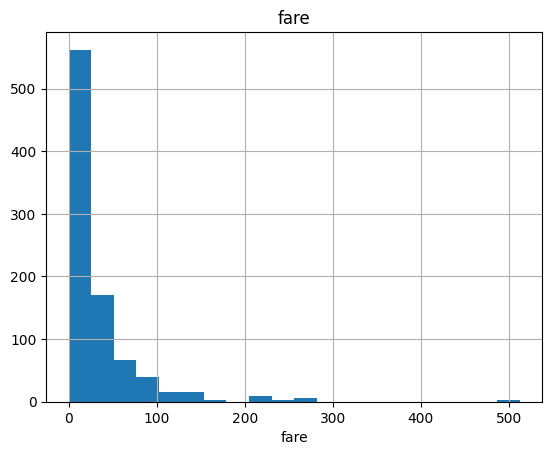

--------------------------------------------------------------------------------------------------------
count    891.000000
mean       1.904602
std        1.613459
min        1.000000
5%         1.000000
10%        1.000000
20%        1.000000
30%        1.000000
40%        1.000000
50%        1.000000
60%        1.000000
70%        2.000000
80%        3.000000
90%        4.000000
95%        6.000000
99%        8.000000
max       11.000000
Name: n_family_size, dtype: float64
--------------------------------------------------------------------------------------------------------


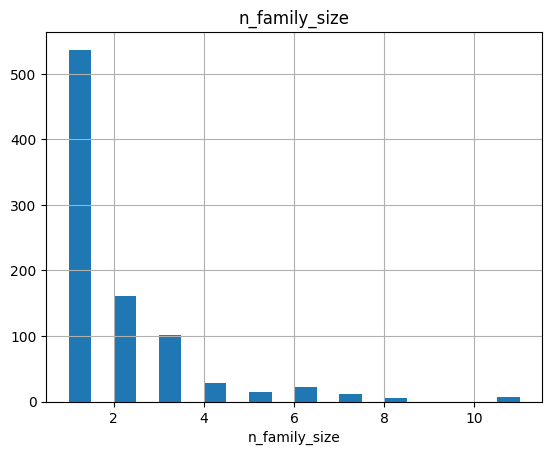

--------------------------------------------------------------------------------------------------------


In [238]:
for col in num_cols:    
    numericals_summary(df, col, plot=True)

# Check Outliers

In [239]:
def outlier_thresholds(dataframe, column_name, q1 = 0.25, q3 = 0.75, print_info=True):
    q1_num = dataframe[column_name].quantile(q1)
    q3_num = dataframe[column_name].quantile(q3)
    iqr = q3_num - q1_num
    lower_threshold = q1_num - iqr * 1.5
    upper_threshold = q3_num + iqr * 1.5
    if print_info:
        print("-----------------------------------------------------------------------------------------------------------")
        print(f"for {column_name}:")
        print("-----------------------------------------------------------------------------------------------------------")
        print(f"Q1 is {q1}")
        print(f"Q3 is {q3}")
        print(f"Q1 threshold is {q1_num}")
        print(f"Q3 threshold is {q3_num}")
        print(f"IQR is {iqr}")
        print(f"Lower threshold is {lower_threshold}")
        print(f"Upper Threshold is {upper_threshold}")
        print("-----------------------------------------------------------------------------------------------------------")
    return lower_threshold, upper_threshold
#----------------------------------------------------------------------------------------------------------------------
def check_if_outlier_exists(dataframe, column_name, q1 = 0.25, q3 = 0.75, print_details=True):
    low_limit, up_limit = outlier_thresholds(dataframe, column_name, q1, q3, print_details)
    if dataframe[((dataframe[column_name] < low_limit) | (dataframe[column_name] > up_limit))].shape[0] > 0:
        print("-----------------------------------------------------------------------------------------------------------")
        print(f"{column_name} : Outliers exist based on Q1={q1} and Q3={q3}")
        print("-----------------------------------------------------------------------------------------------------------")
        print(f"Under lower bound: {len(dataframe[dataframe[column_name] < low_limit])} observation of {len(dataframe)}")
        print(f"Above upper bound: {len(dataframe[dataframe[column_name] > up_limit])} observation of {len(dataframe)}")
        print("-------------------------------------------------------------------------------------------------------")
        return True
    else:
        print("-----------------------------------------------------------------------------------------------------------")
        print(f"{column_name} : No Outlier based on Q1={q1} and Q3={q3}")
        print("-------------------------------------------------------------------------------------------------------")
        return False
#----------------------------------------------------------------------------------------------------------------------

In [240]:
for col in num_cols:
    print(col, check_if_outlier_exists(df, col, 0.05, 0.95))

-----------------------------------------------------------------------------------------------------------
for age:
-----------------------------------------------------------------------------------------------------------
Q1 is 0.05
Q3 is 0.95
Q1 threshold is 4.0
Q3 threshold is 56.0
IQR is 52.0
Lower threshold is -74.0
Upper Threshold is 134.0
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
age : No Outlier based on Q1=0.05 and Q3=0.95
-------------------------------------------------------------------------------------------------------
age False
-----------------------------------------------------------------------------------------------------------
for fare:
-----------------------------------------------------------------------------------------------------------
Q1 is 0.05
Q3 is 0.95
Q1 threshold is 7.225
Q3 t

## >> Winsorise thresholds

In [241]:
def winsorize_with_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
    dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit
#----------------------------------------------------------------------------------------------------------------------

In [242]:
for col in num_cols:
    winsorize_with_thresholds(df, col, 0.05, 0.95)

for col in num_cols:
    print(col, check_if_outlier_exists(df, col, 0.05, 0.95))

-----------------------------------------------------------------------------------------------------------
for age:
-----------------------------------------------------------------------------------------------------------
Q1 is 0.05
Q3 is 0.95
Q1 threshold is 4.0
Q3 threshold is 56.0
IQR is 52.0
Lower threshold is -74.0
Upper Threshold is 134.0
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
for fare:
-----------------------------------------------------------------------------------------------------------
Q1 is 0.05
Q3 is 0.95
Q1 threshold is 7.225
Q3 threshold is 112.07915
IQR is 104.85415
Lower threshold is -150.056225
Upper Threshold is 269.360375
-----------------------------------------------------------------------------------------------------------
------------------------------------------------------------

# Check for Missing Values

In [243]:
df.isnull().sum()

passengerid        0
survived           0
pclass             0
name               0
sex                0
age              177
sibsp              0
parch              0
ticket             0
fare               0
cabin            687
embarked           2
n_has_cabin        0
n_name_dr          0
n_title            0
n_family_size      0
n_is_alone         0
n_age_cat        177
n_sex_cat        177
dtype: int64

## >> Dropping 'cabin' variable as it is mostly empty (77% empty) and other cardinal variables ('passengerid','ticket','name')

In [244]:
# drop columns
list_to_drop = ['ticket','name','cabin']
df.drop(labels=list_to_drop, axis=1, inplace=True)

# reassign categorical variables
cat_cols = ["pclass", "sex","sibsp","parch","embarked","n_name_dr","n_title","n_is_alone","n_age_cat","n_sex_cat"] 
car_cols = ["passengerid"]
df.head()

,passengerid,survived,pclass,sex,age,sibsp,parch,fare,embarked,n_has_cabin,n_name_dr,n_title,n_family_size,n_is_alone,n_age_cat,n_sex_cat
0,1,0,3,male,22.0,1,0,7.2500,S,0,0,Mr,2.0,No,Mature,Mature male
1,2,1,1,female,38.0,1,0,71.2833,C,1,0,Mrs,2.0,No,Mature,Mature female
2,3,1,3,female,26.0,0,0,7.9250,S,0,0,Miss,1.0,Yes,Mature,Mature female
3,4,1,1,female,35.0,1,0,53.1000,S,1,0,Mrs,2.0,No,Mature,Mature female
4,5,0,3,male,35.0,0,0,8.0500,S,0,0,Mr,1.0,Yes,Mature,Mature male


## >> Fill 'age' variable with the medians considering 'n_title' variable and fill rest with means considering there 'sex'

In [245]:
# fill 'age' according to the classes of 't_title'
df["age"].fillna(df.groupby('n_title')["age"].transform("median"), inplace=True)
#df["age"].fillna(df.groupby('sex')["age"].transform("mean"), inplace=True)
df.isnull().sum()

passengerid        0
survived           0
pclass             0
sex                0
age                0
sibsp              0
parch              0
fare               0
embarked           2
n_has_cabin        0
n_name_dr          0
n_title            0
n_family_size      0
n_is_alone         0
n_age_cat        177
n_sex_cat        177
dtype: int64

## >> Convert 'age' to int from float

In [246]:
df["age"] = df["age"].astype(int)
df["age"].dtype

dtype('int64')

## >> Fill 'age' related variables accordingly

In [247]:
# is alone
df.loc[((df['sibsp'] + df['parch']) > 0), "n_is_alone"] = "No"
df.loc[((df['sibsp'] + df['parch']) == 0), "n_is_alone"] = "Yes"

# age level
df.loc[(df['age'] < 18), 'n_age_cat'] = 'Young'
df.loc[(df['age'] >= 18) & (df['age'] < 56), 'n_age_cat'] = 'Mature'
df.loc[(df['age'] >= 56), 'n_age_cat'] = 'Senior'

# sex according to age
df.loc[(df['sex'] == 'male') & (df['age'] <= 21), 'n_sex_cat'] = 'Young male'
df.loc[(df['sex'] == 'male') & (df['age'] > 21) & (df['age'] < 50), 'n_sex_cat'] = 'Mature male'
df.loc[(df['sex'] == 'male') & (df['age'] >= 50), 'n_sex_cat'] = 'Senior male'
df.loc[(df['sex'] == 'female') & (df['age'] <= 21), 'n_sex_cat'] = 'Young female'
df.loc[(df['sex'] == 'female') & (df['age'] > 21) & (df['age'] < 50), 'n_sex_cat'] = 'Mature female'
df.loc[(df['sex'] == 'female') & (df['age'] >= 50), 'n_sex_cat'] = 'Senior female'

print("-"*33)
print("New Shape of Dataset:")
print("-"*33)
print(df.shape)
print("-"*33)
print(df.isnull().sum())
print("-"*33)
df.head()

---------------------------------
New Shape of Dataset:
---------------------------------
(891, 16)
---------------------------------
passengerid      0
survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
embarked         2
n_has_cabin      0
n_name_dr        0
n_title          0
n_family_size    0
n_is_alone       0
n_age_cat        0
n_sex_cat        0
dtype: int64
---------------------------------


,passengerid,survived,pclass,sex,age,sibsp,parch,fare,embarked,n_has_cabin,n_name_dr,n_title,n_family_size,n_is_alone,n_age_cat,n_sex_cat
0,1,0,3,male,22,1,0,7.2500,S,0,0,Mr,2.0,No,Mature,Mature male
1,2,1,1,female,38,1,0,71.2833,C,1,0,Mrs,2.0,No,Mature,Mature female
2,3,1,3,female,26,0,0,7.9250,S,0,0,Miss,1.0,Yes,Mature,Mature female
3,4,1,1,female,35,1,0,53.1000,S,1,0,Mrs,2.0,No,Mature,Mature female
4,5,0,3,male,35,0,0,8.0500,S,0,0,Mr,1.0,Yes,Mature,Mature male


## >> Fill 'embarked' variable with the median considering 'pclass' variable

In [248]:
df["embarked"].fillna(df['embarked'].mode()[0], inplace=True)
df.isnull().sum()

passengerid      0
survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
embarked         0
n_has_cabin      0
n_name_dr        0
n_title          0
n_family_size    0
n_is_alone       0
n_age_cat        0
n_sex_cat        0
dtype: int64

# Label Encoding

## >> Find Binary Variables

In [249]:
# find binary variables
binary_cols = [col for col in df.columns if col in cat_cols and df[col].nunique() == 2]

print("-"*33)
print(f"Binary Variables: {binary_cols}")
print("-"*33)
df.head()

---------------------------------
Binary Variables: ['sex', 'n_name_dr', 'n_is_alone']
---------------------------------


,passengerid,survived,pclass,sex,age,sibsp,parch,fare,embarked,n_has_cabin,n_name_dr,n_title,n_family_size,n_is_alone,n_age_cat,n_sex_cat
0,1,0,3,male,22,1,0,7.2500,S,0,0,Mr,2.0,No,Mature,Mature male
1,2,1,1,female,38,1,0,71.2833,C,1,0,Mrs,2.0,No,Mature,Mature female
2,3,1,3,female,26,0,0,7.9250,S,0,0,Miss,1.0,Yes,Mature,Mature female
3,4,1,1,female,35,1,0,53.1000,S,1,0,Mrs,2.0,No,Mature,Mature female
4,5,0,3,male,35,0,0,8.0500,S,0,0,Mr,1.0,Yes,Mature,Mature male


## >> Binary Label Encoding

In [250]:
le = LabelEncoder()

for col in binary_cols:
    df[col] =le.fit_transform(df[col])
    
df.head()

,passengerid,survived,pclass,sex,age,sibsp,parch,fare,embarked,n_has_cabin,n_name_dr,n_title,n_family_size,n_is_alone,n_age_cat,n_sex_cat
0,1,0,3,1,22,1,0,7.2500,S,0,0,Mr,2.0,0,Mature,Mature male
1,2,1,1,0,38,1,0,71.2833,C,1,0,Mrs,2.0,0,Mature,Mature female
2,3,1,3,0,26,0,0,7.9250,S,0,0,Miss,1.0,1,Mature,Mature female
3,4,1,1,0,35,1,0,53.1000,S,1,0,Mrs,2.0,0,Mature,Mature female
4,5,0,3,1,35,0,0,8.0500,S,0,0,Mr,1.0,1,Mature,Mature male


## >> Find categorical variables with multiple classes

In [251]:
one_hot_cols = [col for col in df.columns if col in cat_cols and df[col].nunique() > 2]
print(f"Categorical variables with multiple classes: {one_hot_cols}")

Categorical variables with multiple classes: ['pclass', 'sibsp', 'parch', 'embarked', 'n_title', 'n_age_cat', 'n_sex_cat']


## >> One-Hot Label Encoding

In [252]:
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)
df.head()

,passengerid,survived,sex,age,fare,n_has_cabin,n_name_dr,n_family_size,n_is_alone,pclass_2,...,n_title_Ms,n_title_Rev,n_title_Sir,n_age_cat_Senior,n_age_cat_Young,n_sex_cat_Mature male,n_sex_cat_Senior female,n_sex_cat_Senior male,n_sex_cat_Young female,n_sex_cat_Young male
0,1,0,1,22,7.2500,0,0,2.0,0,False,...,False,False,False,False,False,True,False,False,False,False
1,2,1,0,38,71.2833,1,0,2.0,0,False,...,False,False,False,False,False,False,False,False,False,False
2,3,1,0,26,7.9250,0,0,1.0,1,False,...,False,False,False,False,False,False,False,False,False,False
3,4,1,0,35,53.1000,1,0,2.0,0,False,...,False,False,False,False,False,False,False,False,False,False
4,5,0,1,35,8.0500,0,0,1.0,1,False,...,False,False,False,False,False,True,False,False,False,False


# Scaling

## >> Apply StandardScaler to numarical values

In [253]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

,passengerid,survived,sex,age,fare,n_has_cabin,n_name_dr,n_family_size,n_is_alone,pclass_2,...,n_title_Ms,n_title_Rev,n_title_Sir,n_age_cat_Senior,n_age_cat_Young,n_sex_cat_Mature male,n_sex_cat_Senior female,n_sex_cat_Senior male,n_sex_cat_Young female,n_sex_cat_Young male
0,1,0,1,-0.555502,-0.556776,0,0,0.059160,0,False,...,False,False,False,False,False,True,False,False,False,False
1,2,1,0,0.650228,0.920354,1,0,0.059160,0,False,...,False,False,False,False,False,False,False,False,False,False
2,3,1,0,-0.254069,-0.541205,0,0,-0.560975,1,False,...,False,False,False,False,False,False,False,False,False,False
3,4,1,0,0.424154,0.500899,1,0,0.059160,0,False,...,False,False,False,False,False,False,False,False,False,False
4,5,0,1,0.424154,-0.538322,0,0,-0.560975,1,False,...,False,False,False,False,False,True,False,False,False,False


# Modelling

## >> Prepare Test Data

In [254]:
def prepare_test_data():
    df = pd.read_csv("/kaggle/input/titanic/test.csv")
    df.columns = [col.lower() for col in df.columns]
    # passeger have a cabin
    df["n_has_cabin"] = df["cabin"].notnull().astype(int)
    # 'dr in name
    df["n_name_dr"] = df["name"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
    # 'title' in name
    df['n_title'] = df["name"].str.extract(' ([A-Za-z]+)\.', expand=False)
    # family size
    df["n_family_size"] = df["sibsp"] + df["parch"] + 1
    # age pclass
    #df["n_age_class"] = df["age"] * df["pclass"]
    # is alone
    df.loc[((df['sibsp'] + df['parch']) > 0), "n_is_alone"] = "No"
    df.loc[((df['sibsp'] + df['parch']) == 0), "n_is_alone"] = "Yes"
    # age level
    df.loc[(df['age'] < 18), 'n_age_cat'] = 'Young'
    df.loc[(df['age'] >= 18) & (df['age'] < 56), 'n_age_cat'] = 'Mature'
    df.loc[(df['age'] >= 56), 'n_age_cat'] = 'Senior'
    # sex according to age
    df.loc[(df['sex'] == 'male') & (df['age'] <= 21), 'n_sex_cat'] = 'Young male'
    df.loc[(df['sex'] == 'male') & (df['age'] > 21) & (df['age'] < 50), 'n_sex_cat'] = 'Mature male'
    df.loc[(df['sex'] == 'male') & (df['age'] >= 50), 'n_sex_cat'] = 'Senior male'
    df.loc[(df['sex'] == 'female') & (df['age'] <= 21), 'n_sex_cat'] = 'Young female'
    df.loc[(df['sex'] == 'female') & (df['age'] > 21) & (df['age'] < 50), 'n_sex_cat'] = 'Mature female'
    df.loc[(df['sex'] == 'female') & (df['age'] >= 50), 'n_sex_cat'] = 'Senior female'
    cat_cols = ["pclass", "sex","sibsp","parch","cabin", "embarked","n_name_dr","n_title","n_age_class","n_is_alone","n_age_cat","n_sex_cat"] 
    num_cols = ["age","fare","n_family_size"]
    car_cols = ["passengerid", "name","ticket"]
    target_label = ''
    for col in num_cols:
        winsorize_with_thresholds(df, col, 0.05, 0.95)
    # drop columns
    list_to_drop = ['ticket','name','cabin']
    df.drop(labels=list_to_drop, axis=1, inplace=True)
    # reassign categorical variables
    cat_cols = ["pclass", "sex","sibsp","parch","embarked","n_name_dr","n_title","n_age_class","n_is_alone","n_age_cat","n_sex_cat"] 
    car_cols = ["passengerid"]
    # fill 'age' according to the classes of 't_title'
    df["age"].fillna(df.groupby('n_title')["age"].transform("median"), inplace=True)
    df["age"].fillna(df.groupby('sex')["age"].transform("mean"), inplace=True)
    df["age"] = df["age"].astype(int)
    # age pclass
    #df["n_age_class"] = df["age"] * df["pclass"]
    # is alone
    df.loc[((df['sibsp'] + df['parch']) > 0), "n_is_alone"] = "No"
    df.loc[((df['sibsp'] + df['parch']) == 0), "n_is_alone"] = "Yes"
    # age level
    df.loc[(df['age'] < 18), 'n_age_cat'] = 'Young'
    df.loc[(df['age'] >= 18) & (df['age'] < 56), 'n_age_cat'] = 'Mature'
    df.loc[(df['age'] >= 56), 'n_age_cat'] = 'Senior'
    # sex according to age
    df.loc[(df['sex'] == 'male') & (df['age'] <= 21), 'n_sex_cat'] = 'Young male'
    df.loc[(df['sex'] == 'male') & (df['age'] > 21) & (df['age'] < 50), 'n_sex_cat'] = 'Mature male'
    df.loc[(df['sex'] == 'male') & (df['age'] >= 50), 'n_sex_cat'] = 'Senior male'
    df.loc[(df['sex'] == 'female') & (df['age'] <= 21), 'n_sex_cat'] = 'Young female'
    df.loc[(df['sex'] == 'female') & (df['age'] > 21) & (df['age'] < 50), 'n_sex_cat'] = 'Mature female'
    df.loc[(df['sex'] == 'female') & (df['age'] >= 50), 'n_sex_cat'] = 'Senior female'
    df["fare"].fillna(df.groupby('pclass')["fare"].transform("mean"), inplace=True)
    df["embarked"].fillna(df['embarked'].mode()[0], inplace=True)
    # find binary variables
    binary_cols = [col for col in df.columns if col in cat_cols and df[col].nunique() == 2]
    le = LabelEncoder()

    for col in binary_cols:
        df[col] =le.fit_transform(df[col])
    one_hot_cols = [col for col in df.columns if col in cat_cols and df[col].nunique() > 2]
    df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df

In [255]:
df_test = prepare_test_data()
df_test.head()

-----------------------------------------------------------------------------------------------------------
for age:
-----------------------------------------------------------------------------------------------------------
Q1 is 0.05
Q3 is 0.95
Q1 threshold is 8.0
Q3 threshold is 57.0
IQR is 49.0
Lower threshold is -65.5
Upper Threshold is 130.5
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
for fare:
-----------------------------------------------------------------------------------------------------------
Q1 is 0.05
Q3 is 0.95
Q1 threshold is 7.2292
Q3 threshold is 151.55
IQR is 144.32080000000002
Lower threshold is -209.25200000000004
Upper Threshold is 368.0312
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------

,passengerid,sex,age,fare,n_has_cabin,n_name_dr,n_family_size,n_is_alone,pclass_2,pclass_3,...,n_title_Mrs,n_title_Ms,n_title_Rev,n_age_cat_Senior,n_age_cat_Young,n_sex_cat_Mature male,n_sex_cat_Senior female,n_sex_cat_Senior male,n_sex_cat_Young female,n_sex_cat_Young male
0,892,1,0.341431,-0.514781,0,0,-0.588285,1,False,True,...,False,False,False,False,False,True,False,False,False,False
1,893,0,1.343772,-0.530361,0,0,0.132839,0,False,True,...,True,False,False,False,False,False,False,False,False,False
2,894,1,2.500320,-0.479865,0,0,-0.588285,1,True,False,...,False,False,False,True,False,False,False,True,False,False
3,895,1,-0.198292,-0.499124,0,0,-0.588285,1,False,True,...,False,False,False,False,False,True,False,False,False,False
4,896,0,-0.583808,-0.431012,0,0,0.853962,0,False,True,...,True,False,False,False,False,False,False,False,False,False


## >> Get only columns exists in both train and test dataset as they do not have the same variables after feature extraction in both datasets

In [256]:
df_train_cols = {col for col in df.columns if col != 'survived'}
df_test_cols = {col for col in df_test.columns}

intersect_cols = df_train_cols.intersection(df_test_cols)

intersect_cols = list(intersect_cols)
intersect_cols

['sibsp_5',
 'n_title_Miss',
 'parch_2',
 'n_is_alone',
 'sibsp_2',
 'parch_5',
 'n_sex_cat_Senior female',
 'sibsp_3',
 'n_has_cabin',
 'sibsp_8',
 'embarked_S',
 'n_title_Ms',
 'sex',
 'parch_3',
 'parch_4',
 'n_sex_cat_Mature male',
 'n_family_size',
 'n_title_Mrs',
 'n_sex_cat_Senior male',
 'embarked_Q',
 'n_title_Dr',
 'n_name_dr',
 'n_title_Master',
 'age',
 'parch_6',
 'n_title_Mr',
 'pclass_2',
 'parch_1',
 'sibsp_4',
 'pclass_3',
 'n_age_cat_Senior',
 'n_title_Rev',
 'fare',
 'sibsp_1',
 'n_sex_cat_Young female',
 'passengerid',
 'n_age_cat_Young',
 'n_sex_cat_Young male']

## >> Prepare Train Data for models

In [257]:
# split data into depentdent and independent variables
X = df[intersect_cols]
y = df[target_label]

# K-Nearest Neighbors Model

## >> Train Model

In [258]:
# train model
knn = KNeighborsClassifier()

knn_params = {"n_neighbors": range(2,50)}

knn_grid = GridSearchCV(knn,
                        knn_params,
                        cv=5,
                        n_jobs=-1,
                        verbose=True).fit(X, y)

knn_grid.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'n_neighbors': 34}

## >> Hyperparameters

In [259]:
# model with hyperparameters
knn_hp = knn.set_params(**knn_grid.best_params_).fit(X,y)

cv_output = cross_validate(knn_hp,
                           X,
                           y,
                           cv=10,
                           scoring=["accuracy","f1","roc_auc"])
print("-"*33)
print(f"Test Accuracy: {cv_output['test_accuracy'].mean():.4f}")
print("-"*33)
print(f"Test F1: {cv_output['test_f1'].mean():.4f}")
print("-"*33)
print(f"Test ROC AUC: {cv_output['test_roc_auc'].mean():.4f}")
print("-"*33)

---------------------------------
Test Accuracy: 0.5746
---------------------------------
Test F1: 0.0874
---------------------------------
Test ROC AUC: 0.4144
---------------------------------


## >> Get Prediction for Test Data

In [260]:
y_pred = knn_hp.predict(df_test[intersect_cols])

df_test["survived"] = y_pred

df_test.head()

,passengerid,sex,age,fare,n_has_cabin,n_name_dr,n_family_size,n_is_alone,pclass_2,pclass_3,...,n_title_Ms,n_title_Rev,n_age_cat_Senior,n_age_cat_Young,n_sex_cat_Mature male,n_sex_cat_Senior female,n_sex_cat_Senior male,n_sex_cat_Young female,n_sex_cat_Young male,survived
0,892,1,0.341431,-0.514781,0,0,-0.588285,1,False,True,...,False,False,False,False,True,False,False,False,False,0
1,893,0,1.343772,-0.530361,0,0,0.132839,0,False,True,...,False,False,False,False,False,False,False,False,False,0
2,894,1,2.500320,-0.479865,0,0,-0.588285,1,True,False,...,False,False,True,False,False,False,True,False,False,0
3,895,1,-0.198292,-0.499124,0,0,-0.588285,1,False,True,...,False,False,False,False,True,False,False,False,False,0
4,896,0,-0.583808,-0.431012,0,0,0.853962,0,False,True,...,False,False,False,False,False,False,False,False,False,0


# Random Forest Classifier

## >> Train Model and Find Accuracy

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("-"*33)
print(f"Model Accuracy is: {accuracy_score(y_pred, y_test):.4f}")
print("-"*33)

---------------------------------
Model Accuracy is: 0.7948
---------------------------------


## >> Find Hyperparameters

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

rf = RandomForestClassifier()
rf_params = {"n_estimators":[10,50,100,150,200],
            "max_depth":[None,10,20,30,50]}

rf_grid = GridSearchCV(rf,
                      rf_params,
                      cv=10,
                      n_jobs=-1,
                      verbose=True,
                      scoring="accuracy").fit(X_train,y_train)

rf_grid.best_params_

Fitting 10 folds for each of 25 candidates, totalling 250 fits


{'max_depth': 10, 'n_estimators': 200}

## >> Get Accuracy Score

In [263]:
rf_hp = rf.set_params(**rf_grid.best_params_).fit(X_train,y_train)

y_pred = rf_hp.predict(X_test)

print("-"*33)
print(f"Model Accuracy is: {accuracy_score(y_pred, y_test):.4f}")
print("-"*33)

---------------------------------
Model Accuracy is: 0.8284
---------------------------------


## >> Get Prediction for Test Data

In [264]:
y_pred = rf_hp.predict(df_test[intersect_cols])

df_test["survived"] = y_pred

df_test.head()

,passengerid,sex,age,fare,n_has_cabin,n_name_dr,n_family_size,n_is_alone,pclass_2,pclass_3,...,n_title_Ms,n_title_Rev,n_age_cat_Senior,n_age_cat_Young,n_sex_cat_Mature male,n_sex_cat_Senior female,n_sex_cat_Senior male,n_sex_cat_Young female,n_sex_cat_Young male,survived
0,892,1,0.341431,-0.514781,0,0,-0.588285,1,False,True,...,False,False,False,False,True,False,False,False,False,0
1,893,0,1.343772,-0.530361,0,0,0.132839,0,False,True,...,False,False,False,False,False,False,False,False,False,0
2,894,1,2.500320,-0.479865,0,0,-0.588285,1,True,False,...,False,False,True,False,False,False,True,False,False,0
3,895,1,-0.198292,-0.499124,0,0,-0.588285,1,False,True,...,False,False,False,False,True,False,False,False,False,0
4,896,0,-0.583808,-0.431012,0,0,0.853962,0,False,True,...,False,False,False,False,False,False,False,False,False,1


# FINAL: Random Forest Classifier Model >> Accuracy is: 82.84%